# Parallel computing and reusing realizations

In this example, we demonstrate two features of the library that help reduce calculation time:
* Parallel computing – a method of performing multiple calculations simultaneously to improve efficiency.
* Reusing realizations – avoiding redundant computations by utilizing previously generated realizations.

We apply these features to calculate the probability of levee failure due to wave overtopping.

First, we import the necessary packages:

In [9]:
from probabilistic_library import ReliabilityProject, DistributionType, ReliabilityMethod
import time

We consider a limit state function for wave overtopping (which we have artificially slowed down):

In [10]:
from utils.models import ZFunctionOvertopping

And the following project, in which we apply the `crude_monte_carlo` method:

In [11]:
def define_project():

    project = ReliabilityProject()
    project.model = ZFunctionOvertopping.z_sleep
    
    project.variables["h"].distribution = DistributionType.log_normal
    project.variables["h"].mean = 1.5
    project.variables["h"].deviation = 0.05

    project.variables["hm0"].distribution = DistributionType.log_normal
    project.variables["hm0"].mean = 1.5
    project.variables["hm0"].deviation = 0.25

    project.variables["tm10"].distribution = DistributionType.log_normal
    project.variables["tm10"].mean = 3
    project.variables["tm10"].deviation = 0.5

    project.variables["wave_direction"].distribution = DistributionType.deterministic
    project.variables["wave_direction"].mean = 0.0

    project.variables["dike_normal"].distribution = DistributionType.deterministic
    project.variables["dike_normal"].mean = 0.0

    project.variables["y_crest"].distribution = DistributionType.deterministic
    project.variables["y_crest"].mean = 6.0

    project.variables["q_crit"].distribution = DistributionType.log_normal
    project.variables["q_crit"].mean = 0.001
    project.variables["q_crit"].deviation = 0.01

    project.settings.reliability_method = ReliabilityMethod.crude_monte_carlo
    project.settings.minimum_samples = 1000
    project.settings.maximum_samples = 1000
    project.settings.variation_coefficient = 0.02

    return project

### Parallel computing

If not specified, the calculations are performed on a single processor. To utilize multiple processors, we adjust the setting `project.settings.max_parallel_processes`. 

With the following code, we analyze the effect of parallel computing on the calculation time:

Max parallel processes: 1
Time elapsed: 100.65113615989685 seconds
Reliability:
 Reliability index = 1.227
 Probability of failure = 0.11
 Convergence = 0.08995 (not converged)
 Model runs = 1001
Alpha values:
 self: alpha = 0, x = 0
 h: alpha = -0.04342, x = 1.502
 hm0: alpha = -0.3716, x = 1.596
 tm10: alpha = -0.6051, x = 3.346
 wave_direction: alpha = 0, x = 0
 dike_normal: alpha = 0, x = 0
 y_crest: alpha = 0, x = 6
 q_crit: alpha = 0.7027, x = 1.562e-05

Max parallel processes: 4
Time elapsed: 25.75580382347107 seconds
Reliability:
 Reliability index = 1.227
 Probability of failure = 0.11
 Convergence = 0.08995 (not converged)
 Model runs = 1001
Alpha values:
 self: alpha = 0, x = 0
 h: alpha = -0.04342, x = 1.502
 hm0: alpha = -0.3716, x = 1.596
 tm10: alpha = -0.6051, x = 3.346
 wave_direction: alpha = 0, x = 0
 dike_normal: alpha = 0, x = 0
 y_crest: alpha = 0, x = 6
 q_crit: alpha = 0.7027, x = 1.562e-05

Max parallel processes: 8
Time elapsed: 13.256065130233765 seconds
Reli

Text(0, 0.5, 'Elapsed time (s)')

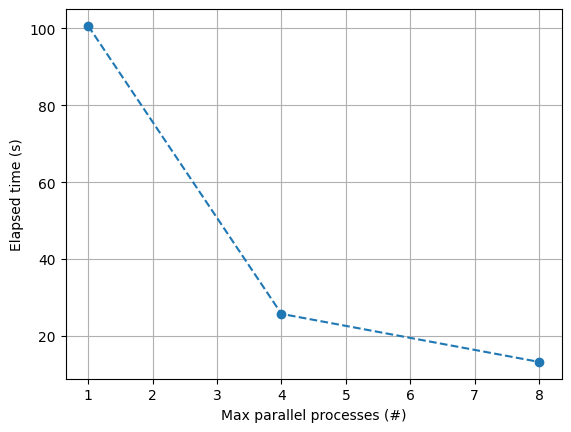

In [ ]:
max_parallel_processes = [1, 4, 8]
elapsed = []

for val in max_parallel_processes:

    project = define_project()
    project.settings.max_parallel_processes = val

    t = time.time()
    project.run()
    elapsed.append(time.time() - t)
    
    print(f"Max parallel processes: {val}")
    print(f"Time elapsed: {elapsed[-1]} seconds")

    project.design_point.print()

import matplotlib.pyplot as plt
plt.plot(max_parallel_processes, elapsed, 'o--')
plt.grid()
plt.xlabel('Max parallel processes (#)')
plt.ylabel('Elapsed time (s)')
plt.show()


### Reusing realizations

Another useful feature of the library is the ability to reuse realizations - this is possible if the project is not redefined when it is run again.

This functionality is particularly valuable in sensitivity analyses (if multiple model outputs are required). It is also beneficial when applying the Crude Monte Carlo method in reliability analysis. For instance, if a calculation is first performed with $200$ samples and later extended to $250$ samples, the initial $200$ samples are reused in the second run, avoiding unnecessary recomputation. 

This is demonstrated in the following example:

In [13]:
project = define_project()
samples = [200, 200, 250]
run_message = ["Initial run", "Run repeated", "Additional 50 runs"]

for id in range(3):
    project.settings.minimum_samples = samples[id]
    project.settings.maximum_samples = samples[id]

    t = time.time()
    project.run()
    elapsed = time.time() - t

    print(f"{run_message[id]}")
    print(f"Time elapsed: {elapsed} seconds")

    project.design_point.print()

Initial run
Time elapsed: 20.227248907089233 seconds
Reliability:
 Reliability index = 1.254
 Probability of failure = 0.105
 Convergence = 0.2064 (not converged)
 Model runs = 201
Alpha values:
 self: alpha = 0, x = 0
 h: alpha = 0.01244, x = 1.498
 hm0: alpha = -0.4622, x = 1.629
 tm10: alpha = -0.5703, x = 3.331
 wave_direction: alpha = 0, x = 0
 dike_normal: alpha = 0, x = 0
 y_crest: alpha = 0, x = 6
 q_crit: alpha = 0.679, x = 1.599e-05

Run repeated
Time elapsed: 0.0009968280792236328 seconds
Reliability:
 Reliability index = 1.254
 Probability of failure = 0.105
 Convergence = 0.2064 (not converged)
 Model runs = 0
Alpha values:
 self: alpha = 0, x = 0
 h: alpha = 0.01244, x = 1.498
 hm0: alpha = -0.4622, x = 1.629
 tm10: alpha = -0.5703, x = 3.331
 wave_direction: alpha = 0, x = 0
 dike_normal: alpha = 0, x = 0
 y_crest: alpha = 0, x = 6
 q_crit: alpha = 0.679, x = 1.599e-05

Additional 50 runs
Time elapsed: 5.025488615036011 seconds
Reliability:
 Reliability index = 1.305
 Pr

It is also possible to disable the reuse of realizations by setting the `project.settings.reuse_calculations` property. This can be done as follows:

In [14]:
project.settings.reuse_calculations = False

project.settings.minimum_samples = samples[-1]
project.settings.maximum_samples = samples[-1]

t = time.time()
project.run()
elapsed = time.time() - t

print(f"{run_message[id]}")
print(f"Time elapsed: {elapsed} seconds")

project.design_point.print()

Additional 50 runs
Time elapsed: 25.2289559841156 seconds
Reliability:
 Reliability index = 1.305
 Probability of failure = 0.096
 Convergence = 0.1941 (not converged)
 Model runs = 251
Alpha values:
 self: alpha = 0, x = 0
 h: alpha = 0.003841, x = 1.499
 hm0: alpha = -0.3906, x = 1.61
 tm10: alpha = -0.5775, x = 3.352
 wave_direction: alpha = 0, x = 0
 dike_normal: alpha = 0, x = 0
 y_crest: alpha = 0, x = 6
 q_crit: alpha = 0.7169, x = 1.334e-05

